In [1]:
 %matplotlib inline
import sys
import numpy as np
import cv2
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import cv2
import numpy as np
import cv2
from matplotlib import pyplot as plt

# sys.path.append("/opt/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/models/research")
# sys.path.append("/opt/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/models/research/object_detection")

sys.path.append("/Users/maurice/Envs/icecreamlabs/lib/python3.5/site-packages/tensorflow/models/research")
sys.path.append("/Users/maurice/Envs/icecreamlabs/lib/python3.5/site-packages/tensorflow/models/research/object_detection")


from tensorflow.models.research.object_detection.utils import label_map_util
from tensorflow.models.research.object_detection.utils import visualization_utils as vis_util

/Users/maurice/Envs/icecreamlabs/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
IMAGE_ALLFRAMES_DIR = "./datacrusader/temp_data/binocular/all"

image_paths = [ "{}/image{}.jpg".format(IMAGE_ALLFRAMES_DIR,i) for i in range(1799,1899)]
images_org = [ cv2.imread(p) for p in image_paths]
images = [ cv2.resize(img,(300,300), interpolation = cv2.INTER_CUBIC) for img in images_org ]

In [205]:
PATH_TO_CKPT = './exports/ssd_mobilenet_v3_coco_class12/frozen_inference_graph.pb'
PATH_TO_LABELS = './datacrusader/generated/binocular/labels_map.pbtxt'
NUM_CLASSES = 12

def show_img(img, size=(15,15)):
    plt.figure(figsize=size)
    plt.imshow(img)

def get_categories(PATH_TO_LABELS, NUM_CLASSES):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return category_index


def load_image_tensor(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    return img

def load_images_tensor(imgs):
    imgs = [ cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    return imgs


def load_graph(PATH_TO_CKPT):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph


def make_inference(image_data, detection_graph, category_index, score_thresh=0.75):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_data}
            )
            image_np = image_data[0]
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                scores=np.squeeze(scores),
                category_index=category_index,
                min_score_thresh=score_thresh,
                use_normalized_coordinates=True,
                max_boxes_to_draw=None,
                line_thickness=1)

    return image_np, classes[scores > score_thresh], scores[scores > score_thresh], boxes[scores > score_thresh]

def make_inferences(images,detection_graph, category_index, score_thresh=0.75):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            
            results = []
            for image_data in images:
                print("image_data",image_data.shape)
                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes, scores, classes, num_detections],
                    feed_dict={image_tensor: np.array([image_data])}
                )
                results.append(( classes[scores > score_thresh], scores[scores > score_thresh], boxes[scores > score_thresh]))
            return results
                        

#     return results


def get_prediction(image, category_index, detection_graph, score_thresh=0.5):
    image_data = load_image_tensor(image)
    prediction, classes, scores, boxes = make_inference(image_data, detection_graph, category_index, score_thresh)
    objects = Counter(classes)
    result = {category_index[k]['name']: v for k, v in objects.items()}
#     print("classes length : {}".format(len(classes)))
    classes = [category_index[i]['name'] for i in classes]
#     print("scores length : {}".format(len(scores)))
#     print("Boxes",boxes)
#     print("Classes",classes)
    main_result = []
    for i in range(len(boxes)):
        main_result.append({'name':classes[i],'box':boxes[i].tolist(),'score':int(100*scores[i])})
    result.update(dict(zip(classes, scores)))
    # result.update(dict(zip(classes, boxes)))
    results = (prediction, result)
    return prediction, main_result


def get_predictions(images, category_index, detection_graph, score_thresh=0.5):
    images_data = load_images_tensor(images)
    
    results = make_inferences(images_data, detection_graph, category_index, score_thresh)
    main_results = []
    for result in results:
        classes, scores, boxes = result
        objects = Counter(classes)
        result = {category_index[k]['name']: v for k, v in objects.items()}
        print("classes length : {}".format(len(classes)))
        classes = [category_index[i]['name'] for i in classes]
        print("scores length : {}".format(len(scores)))
        print("Boxes",boxes)
        print("Classes",classes)
        main_result = []
        for i in range(len(boxes)):
            main_result.append({'name':classes[i],'box':boxes[i].tolist(),'score':int(100*scores[i])})
            
        main_results.append(main_result)
#         result.update(dict(zip(classes, scores)))
        # result.update(dict(zip(classes, boxes)))
#         final_result = (prediction, result)
    return main_results



In [206]:
detection_graph = load_graph(PATH_TO_CKPT)
category_index = get_categories(PATH_TO_LABELS, NUM_CLASSES)
category_vals = [ category_index[v]['name'] for v in category_index]

## Run predictions on all frames

In [212]:
preds = []
for img in tqdm(images_org):
    pred = get_prediction(img, category_index, detection_graph, 0.05)
    preds.append(pred)

100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


In [208]:
preds_imgs = [i[0] for i in preds]
preds_boxes = [i[1] for i in preds]

In [214]:
with open('./datacrusader/temp_data/binocular/preds_boxes3.txt', 'w') as outfile:
    json.dump(preds_boxes, outfile)

In [213]:
for i,img in enumerate(preds_imgs):
    cv2.imwrite('./datacrusader/temp_data/binocular/pred3/image{}.jpg'.format(i+1799),img)

In [215]:
preds_imgs_sub = [cv2.resize(i,None,fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC) for i in preds_imgs]
save_gif(preds_imgs_sub,"./data/predictions3.gif")

## Load Predictions from file

In [230]:
with open('./datacrusader/temp_data/binocular/preds_boxes.txt', 'r') as infile:
    preds_boxes = json.load(infile)

In [231]:
IMAGE_ALLPRED_DIR = "./datacrusader/temp_data/binocular/pred"
pred_paths = [ "{}/image{}.jpg".format(IMAGE_ALLPRED_DIR,i) for i in range(1799,1899)]
preds_imgs = [ cv2.imread(p) for p in pred_paths]

## Get Transformation Matrices

In [216]:

def get_perspectiveM(img1, img2):
#     img1 = np.copy(images[0])
#     img2 = np.copy(images[1])


    # Initiate SIFT detector
    # sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # # Initiate SIFT detector
    # # orb = cv2.ORB()
    # orb = cv2.ORB_create()

    # # find the keypoints and descriptors with SIFT
    # kp1, des1 = orb.detectAndCompute(img1,None)
    # kp2, des2 = orb.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)



    # # store all the good matches as per Lowe's ratio test.
    # good = []
    # for m,n in matches:
    #     if abs(m.distance-n.distance)<20:
    # #     if m.distance < 0.1*n.distance:
    #         good.append(m)

#     print("good matches",len(good))

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    return M

    # Draw first 10 matches.
#     img3 = cv2.drawMatches(img1,kp1,img2,kp2,good[:100], flags=2, outImg=None)

#     plt.figure(figsize=(20,20)),plt.imshow(img3),plt.show()

perspective_map_cache = {}
def get_perspectiveM_frame(f1=0,f2=2):
    key = 'a{}_{}'.format(f1,f2)
    if key not in perspective_map_cache and perspective_map_cache is not None: 
        perspective_map_cache[key] = get_perspectiveM(images[f1],images[f2])
#         print("added in cache",key)
        
#     print("perspective_map_cache",perspective_map_cache,get_perspectiveM(images[f1],images[f2]))
    return perspective_map_cache[key]
    
        




In [217]:
M_all = []
for i in tqdm(range(len(images)-1)):
    M_all.append(get_perspectiveM(images[i],images[i+1]))
    
M_all = np.array(M_all)

100%|██████████| 99/99 [00:13<00:00,  7.59it/s]


In [218]:
from scipy import signal
def smooth_camera_move(M_all):
    M_all = np.copy(M_all)
    for i in range(3):
        for j in range(3):
            y = M_all[:,i,j]
            y_smooth = signal.savgol_filter(y, 53, 10)
            M_all[:,i,j] = y_smooth
    return M_all
            
M_all_smooth = smooth_camera_move(M_all)

In [10]:
perspective_map_cache

{}

In [57]:
M0_20 = get_perspectiveM_frame(0,20)

In [58]:
M0_10 = get_perspectiveM_frame(0,10)

In [59]:
M10_20 = get_perspectiveM_frame(10,20)

In [53]:
np.dot(M10_20,M0_10), np.dot(M10_20,M0_10), M0_20, M0_10, M10_20

(array([[ 1.64446033e+00,  4.39479610e-02, -2.09756709e+02],
        [-9.67918202e-02,  1.22142192e+00, -2.09845965e+01],
        [-6.75486084e-04,  1.13785214e-04,  1.03405308e+00]]),
 array([[ 1.64446033e+00,  4.39479610e-02, -2.09756709e+02],
        [-9.67918202e-02,  1.22142192e+00, -2.09845965e+01],
        [-6.75486084e-04,  1.13785214e-04,  1.03405308e+00]]),
 array([[ 1.76258640e+00,  1.03396009e-02, -2.43437862e+02],
        [-1.19510165e-01,  1.15760055e+00, -1.36831146e+01],
        [-7.02518722e-04,  7.06156002e-05,  1.00000000e+00]]),
 array([[ 1.34328087e+00,  1.71609007e-02, -9.96965434e+01],
        [-2.83772902e-02,  1.12967351e+00, -1.63582219e+01],
        [-1.94494937e-04,  1.92270592e-05,  1.00000000e+00]]),
 array([[ 1.21185112e+00,  2.20016014e-02, -8.85794343e+01],
        [-5.03988872e-02,  1.08212375e+00, -8.30757090e+00],
        [-3.56189327e-04,  8.91148486e-05,  1.00000000e+00]]))

In [15]:
get_perspectiveM_frame(10,20)*get_perspectiveM_frame(0,10)

array([[1.50034491e+00, 3.50748811e-05, 4.14667526e+03],
       [1.06399865e-04, 1.18388155e+00, 1.12761904e+02],
       [6.14317664e-09, 1.47568783e-10, 1.00000000e+00]])

In [60]:
cv2.perspectiveTransform(np.array([[np.array([100.,100.])]]),M0_20)[0][0]

array([10.36394967, 94.42324797])

In [61]:
y = cv2.perspectiveTransform(np.array([[np.array([100.,100.])]]),M0_10)[0][0]
y

array([60.37151238, 96.53841997])

In [62]:
cv2.perspectiveTransform(np.array([[np.array(y)]]),M10_20)[0][0]

array([10.57659057, 94.37411477])

In [219]:
aspect_ratio_fix = np.array(images_org[0].shape[:2])/np.array(images[0].shape[:2])
aspect_ratio_fix

array([ 2.4       ,  4.26666667])

## Track from boxes

In [232]:
for i,k in enumerate(preds_boxes):
    for l in k:
        l['frame'] = i

In [13]:
def get_iou(bb1, bb2):

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [15]:
def get_centroid(box):
    return np.array([(box[3]+box[1])/2,(box[2]+box[0])/2])

def get_distance_points(p1,p2):
    return np.sqrt(np.square(p1[0]-p2[0])+np.square(p1[1]-p2[1]))

def get_distance(b1,b2, M):
    cen_b1 = get_centroid(b1)
    cen_b2 = get_centroid(b2)
#     print("cen_b1",cen_b1)
    
#     cen_b2_shift = cv2.perspectiveTransform(np.array([[np.array(cen_b2)*300]]),M)[0][0]/300
#     print("cen_b2",cen_b2)
#     print("cen_b1_shift",cen_b1_shift,cen_b2_shift)
    cen_b1 = cen_b1*300
    cen_b2 = cen_b2*300
#     print("cen_b10",cen_b1,cen_b2)

#     cen_b1 = cv2.perspectiveTransform(np.array([[np.array(cen_b1)]]),M)[0][0]
#     print("cen_b11",cen_b1,cen_b2)
    cen_b1 = cen_b1*aspect_ratio_fix
    cen_b2 = cen_b2*aspect_ratio_fix
    
#     print("cen_b12",cen_b1,cen_b2)
    
    return get_distance_points(cen_b1, cen_b2)
        
    
# def get_transformed_box(point,M):

def translate_bounds(bound,M):
    tl = [bound[1],bound[0]]
    tr = [bound[1],bound[2]]
    bl = [bound[3],bound[0]]
    br = [bound[3],bound[2]]
    
    tl = np.array(tl)*300
    tr = np.array(tr)*300
    bl = np.array(bl)*300
    br = np.array(br)*300
    
#     print("tl",tl)
    tl = cv2.perspectiveTransform(np.array([[np.array(tl)]]),M)[0][0]
    tr = cv2.perspectiveTransform(np.array([[np.array(tr)]]),M)[0][0]
    bl = cv2.perspectiveTransform(np.array([[np.array(bl)]]),M)[0][0]
    br = cv2.perspectiveTransform(np.array([[np.array(br)]]),M)[0][0]
    
    return np.clip(np.array([ min(tl[1],tr[1]), min(tl[0],bl[0]), max(bl[1],br[1]) , max(tr[0],br[0])])/300,0,1)
    
    

def is_same(b1, b2, M):
    if b1['name']==b2['name']:
#         dist = get_distance(b1["box"],b2["box"], M)
        b1_translated = translate_bounds(b1["box"],M)
        iou = get_iou(b1_translated,b2["box"])
        
        return iou>0.6
#         return dist<3 and iou>0.5
        
    return False
        
# def add_points_to_bound(bound):
    
    
def match_bounds(bounds1, bounds2, M12):
    matches = []
    for b1 in bounds1:
        min_dist = 100
        best_match = None
        for b2 in bounds2:
            if is_same(b1,b2, M12):
                dist = get_distance(b1["box"],b2["box"], M12)
                if min_dist>dist:
                    best_match = [b1,b2]
                    min_dist = dist
        if best_match is not None: matches.append(best_match)
    return matches
    
# matches = match_bounds(preds_boxes[2],preds_boxes[3], M_all_smooth[2])    
# len(matches)

# bound = matches_all2[180][0]
# bound2 = matches_all2[180][-1]
# M_temp = get_perspectiveM(images[bound['frame']], images[bound2['frame']])
# boundt = translate_bounds(bound['box'],M_temp)
# boundt, bound['box'], bound2['box']

In [451]:
x = np.array([[1,0,0],[0,1,0],[0,0,1]])
for i in range(33,40):
    x = M_all_smooth[i]*x
x, M_temp

(array([[ 1.00287177,  0.        , -0.        ],
        [-0.        ,  0.97759593,  0.        ],
        [-0.        ,  0.        ,  0.97076996]]),
 array([[ 1.03379568e+00,  7.43812399e-03, -3.40554141e+01],
        [-3.42044520e-02,  1.00909861e+00,  3.02548654e-01],
        [-2.27874255e-04,  3.38568106e-05,  1.00000000e+00]]))

In [421]:
np.flip([10,200],0)

array([200,  10])

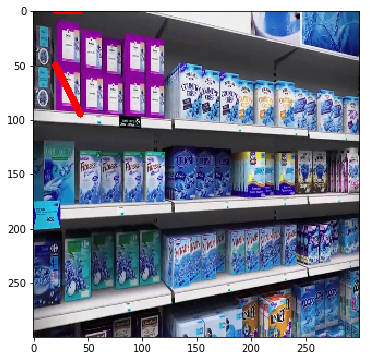

In [423]:
img = np.copy(images[33])
tl = (np.flip(bound['box'][:2],0)*300).astype(int)
br = (np.flip(bound['box'][2:],0)*300).astype(int)
cv2.line(img,tuple(tl),tuple(br),(255,0,0),5)
show_img(img,(6,6))

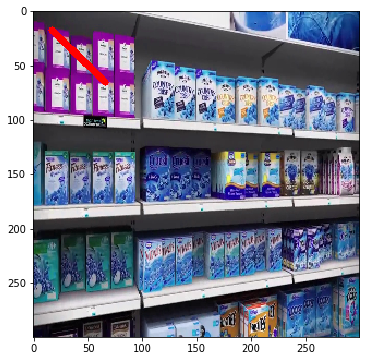

In [426]:
# show_img(images[40],(6,6))
img = np.copy(images[40])
tl = (np.flip(boundt[:2],0)*300).astype(int)
br = (np.flip(boundt[2:],0)*300).astype(int)
cv2.line(img,tuple(tl),tuple(br),(255,0,0),5)
show_img(img,(6,6))

In [233]:
matches_all = []
for i in range(99):    
    matches_all.append(match_bounds(preds_boxes[i],preds_boxes[i+1], M_all_smooth[i]))

In [222]:
len(matches_all), len(matches_all[60])

(99, 9)

In [234]:
matches_all2 = []
for i in tqdm(range(98)):
    ma1 = matches_all[i]
#     ma2 = matches_all[i+1]
    
    joined = []
    for m2 in ma1:
        m2 = m2.copy()
        added = False
        
        
        # Check for n1-n5 connection
        for m1 in matches_all2:
            if m1[-1]['name']==m2[0]['name']:# join them
                if m2[0]['frame']-m1[-1]['frame'] < 30:
                    try:
                        m1_box_translate = translate_bounds(m1[-1]['box'],get_perspectiveM_frame(m1[-1]['frame'],m2[0]['frame']))
                        if get_iou(m1_box_translate,m2[0]['box']) > 0.7:
                            m1.append(m2[1])
                            added = True
                            break
                    except:
                        print("Skipped Error")
                        
        
        # Check for n0 connection
        if not added:
            for m1 in matches_all2:
                if np.array_equal(m1[-1]['box'],m2[0]['box']):# join them
                    m1.append(m2[1])
                    added = True
                    break
                
        # Add as Extra chain
        if not added: matches_all2.append(m2)
    
#     matches_all2.append(joined)
    
#     print("joined",joined)
                
        

100%|██████████| 98/98 [00:00<00:00, 414.17it/s]


In [183]:
matches_all[0]

[[{'box': [0.2474508434534073,
    0.5654972195625305,
    0.35376909375190735,
    0.5942274928092957],
   'frame': 0,
   'name': 'oxlem_pink',
   'score': 99},
  {'box': [0.25104790925979614,
    0.563123345375061,
    0.35356855392456055,
    0.5911680459976196],
   'frame': 1,
   'name': 'oxlem_pink',
   'score': 99}],
 [{'box': [0.1547890454530716,
    0.5999586582183838,
    0.2569296360015869,
    0.6417152881622314],
   'frame': 0,
   'name': 'oxlem_pink',
   'score': 99},
  {'box': [0.14851965010166168,
    0.5912042260169983,
    0.25634610652923584,
    0.6286203265190125],
   'frame': 1,
   'name': 'oxlem_pink',
   'score': 98}],
 [{'box': [0.15670037269592285,
    0.5577291250228882,
    0.24494332075119019,
    0.5854302644729614],
   'frame': 0,
   'name': 'oxlem_pink',
   'score': 96},
  {'box': [0.1548956036567688,
    0.5526055097579956,
    0.24455979466438293,
    0.5776423215866089],
   'frame': 1,
   'name': 'oxlem_pink',
   'score': 97}],
 [{'box': [0.25636518001

In [170]:
matches_all2[0]

[{'box': [0.2474508434534073,
   0.5654972195625305,
   0.35376909375190735,
   0.5942274928092957],
  'frame': 0,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.25104790925979614,
   0.563123345375061,
   0.35356855392456055,
   0.5911680459976196],
  'frame': 1,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.24995344877243042,
   0.5576668381690979,
   0.35247015953063965,
   0.586683452129364],
  'frame': 2,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.23460975289344788,
   0.503877580165863,
   0.3497050106525421,
   0.5406416058540344],
  'frame': 10,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.22904255986213684,
   0.4860475957393646,
   0.3456895649433136,
   0.5251932144165039],
  'frame': 11,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.23041586577892303,
   0.4714186489582062,
   0.34689396619796753,
   0.51240074634552],
  'frame': 12,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.22956828773021698,
   0.45897987484931946,
   0.347495466

In [235]:
matches_all3 = []
for trail in tqdm(matches_all2):
    start = trail[0]
    end = trail[-1]
    new_set = [start]
    prev = start
    for match in trail[1:]:
        while match["frame"] - prev["frame"]>1:
            new_box = translate_bounds(prev['box'],get_perspectiveM_frame(prev['frame'],prev['frame']+1))
            
            tmp = {'box': new_box,
                            'frame': prev["frame"]+1,
                            'name': start['name'],
                            'score': 0}
            prev = tmp
            new_set.append(tmp)
#             print("Added ",tmp)
            
#             break
        
        prev = match
        new_set.append(match)
#         print("Added ",match)
    matches_all3.append(new_set)
    
#         print("aa",match["frame"])
#         for i 

100%|██████████| 53/53 [00:00<00:00, 3061.49it/s]


In [166]:
matches_all2[0]

[{'box': [0.4293575882911682,
   0.9280040860176086,
   0.539487361907959,
   0.9575902819633484],
  'frame': 2,
  'name': 'crunchy_violet',
  'score': 74},
 {'box': [0.4287796914577484,
   0.9304642677307129,
   0.537889301776886,
   0.9636871814727783],
  'frame': 3,
  'name': 'crunchy_violet',
  'score': 43},
 {'box': [0.4276965260505676,
   0.9415197968482971,
   0.5421128273010254,
   0.9765562415122986],
  'frame': 7,
  'name': 'crunchy_violet',
  'score': 53},
 {'box': [0.43184715509414673,
   0.9402077198028564,
   0.547001838684082,
   0.975420355796814],
  'frame': 8,
  'name': 'crunchy_violet',
  'score': 51},
 {'box': [0.4270083010196686,
   0.9273663759231567,
   0.5443581342697144,
   0.9621783494949341],
  'frame': 5,
  'name': 'crunchy_violet',
  'score': 57},
 {'box': [0.42283815145492554,
   0.9650180339813232,
   0.5565328598022461,
   0.9998620748519897],
  'frame': 22,
  'name': 'crunchy_violet',
  'score': 77},
 {'box': [0.4222337007522583,
   0.9668871760368347,


In [189]:
[ x['frame'] for x in new_set], [ x['frame'] for x in matches_all2[0]]

([2,
  3,
  3,
  7,
  4,
  8,
  5,
  18,
  6,
  19,
  7,
  20,
  8,
  21,
  9,
  22,
  10,
  23,
  11,
  24,
  12,
  25,
  13,
  26,
  14,
  27,
  15,
  28,
  16,
  29,
  17,
  30,
  18,
  31,
  19,
  32,
  20,
  33,
  21,
  34,
  22,
  35,
  23,
  36,
  24,
  37,
  25,
  38,
  26,
  39,
  27,
  40,
  28,
  43,
  29,
  44,
  30,
  45,
  31,
  46,
  32,
  47,
  33,
  48,
  34,
  49,
  35,
  50,
  36,
  51,
  37,
  52,
  38,
  53,
  39,
  54,
  40,
  55,
  41,
  56,
  42,
  57,
  43,
  58,
  44,
  59,
  45,
  60,
  46,
  61,
  47,
  62,
  48,
  63,
  49,
  64,
  50,
  65,
  51,
  66,
  52,
  67,
  53,
  68,
  54,
  69,
  55,
  70,
  56,
  71,
  57,
  72,
  58,
  73,
  59,
  74,
  60,
  75,
  61,
  76,
  62,
  77,
  63,
  78,
  64,
  79,
  65,
  80,
  66,
  81,
  67,
  82,
  68,
  83,
  69,
  84,
  70,
  85,
  71,
  86,
  72,
  87,
  73,
  88,
  74,
  89,
  75,
  90,
  76,
  91,
  77,
  92,
  78,
  93,
  79,
  94,
  80,
  95,
  81,
  96,
  82,
  97,
  83,
  98],
 [2,
  3,
  7,
  8,
  18,


In [150]:
len(matches_all2), len(matches_all2[60])

(92, 25)

In [185]:
matches_all2 = sorted(matches_all2,key=lambda x:-len(x))

In [153]:
[ len(i) for i in matches_all2]

[149,
 135,
 129,
 126,
 123,
 122,
 84,
 61,
 60,
 52,
 52,
 52,
 52,
 51,
 50,
 50,
 50,
 50,
 49,
 49,
 48,
 48,
 48,
 47,
 46,
 46,
 39,
 39,
 38,
 38,
 37,
 33,
 33,
 32,
 32,
 31,
 30,
 30,
 28,
 28,
 27,
 26,
 26,
 26,
 25,
 24,
 20,
 17,
 11,
 11,
 11,
 10,
 10,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 7,
 7,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [152]:
len([ len(i) for i in matches_all2 if len(i)>10])

51

## Save Matches

In [29]:
with open('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/preds_matches.txt', 'w') as outfile:
    json.dump(matches_all2, outfile)

## Load Matches

In [ ]:
with open('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/preds_matches.txt', 'r') as infile:
    matches_all2 = json.load(infile)

In [21]:
# len(matches_all2)
chain_lens = [ len(l) for l in matches_all2]
# chain_lens

In [22]:
sorted(chain_lens,reverse=True)[:60]

[84,
 61,
 56,
 53,
 52,
 52,
 50,
 50,
 45,
 45,
 45,
 31,
 30,
 30,
 29,
 27,
 26,
 18,
 18,
 15,
 13,
 10,
 9,
 9,
 8,
 7,
 7,
 7,
 6,
 6,
 6,
 5,
 5,
 5,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [354]:
matches_all2[0]

[{'box': [0.2474508434534073,
   0.5654972195625305,
   0.35376909375190735,
   0.5942274928092957],
  'frame': 0,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.25104790925979614,
   0.563123345375061,
   0.35356855392456055,
   0.5911680459976196],
  'frame': 1,
  'name': 'oxlem_pink',
  'score': 99},
 {'box': [0.24995344877243042,
   0.5576668381690979,
   0.35247015953063965,
   0.586683452129364],
  'frame': 2,
  'name': 'oxlem_pink',
  'score': 99}]

In [23]:
len(matches_all2)

75

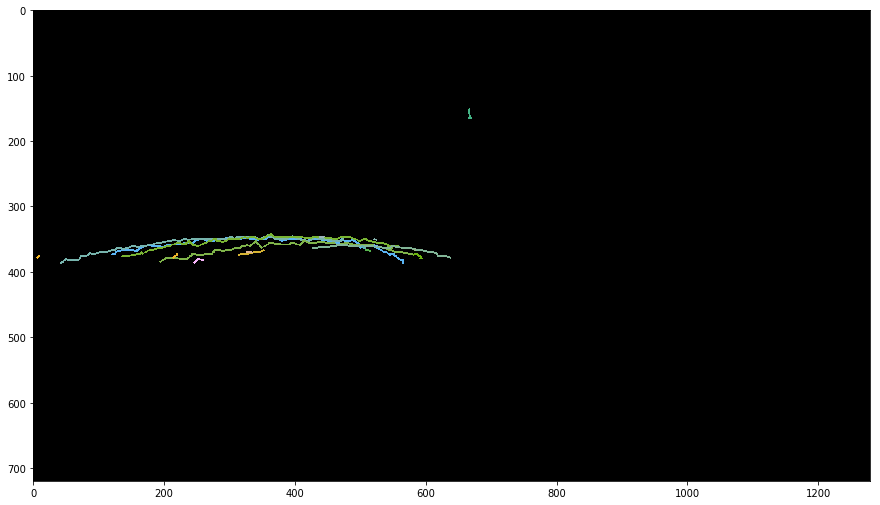

In [24]:
img = np.zeros(images_org[0].shape, np.uint8)

def draw_trace(img,trace,color=[255,0,255]):
    before = None
    
#     print("trace",trace)
    for match in trace:
        cen_b1 = get_centroid(match['box'])
#         print("cen_b1",cen_b1)
        cen_b1 = cen_b1*aspect_ratio_fix*300
        
        cen_b1 = tuple(cen_b1.astype(int))
#         print("cen_b1",cen_b1)
    #     cv2.line(img,(0,0),(511,511),(255,0,0),5)

        if before is not None: cv2.line(img,before,cen_b1,color,2)
        before = cen_b1
    
for trace in matches_all2:
    if trace[0]['name'] != "country_crisp_blue": continue
#     print(trace)
#     print("name",trace[0]['name'])
    color = [ (55+trace[0]['frame']*2), category_vals.index(trace[0]['name'])*60 , np.random.randint(255)]
    draw_trace(img,trace,color)
show_img(img)

In [159]:
len(matches_all2[0])

149

## Create GIfs

In [94]:
import imageio
from IPython.display import HTML
def save_gif(images,output_file="./datacrusader/temp_data/binocular/gif_full_300.GIF"):
    imageio.mimsave(output_file, images, duration=0.2)
    
def show_gif(output_file):
    return HTML('<img src="{}">'.format(output_file))

In [236]:
def draw_bound(bound,img,color=[255,255,0]):
    image_tmp = cv2.drawContours(img, np.array([bound]), -1, color, 5)
    return image_tmp

def get_box_from_bound(bound):
    bound = np.array(bound)*300
    bound[0] = aspect_ratio_fix[0]*bound[0]
    bound[1] = aspect_ratio_fix[1]*bound[1]
    bound[2] = aspect_ratio_fix[0]*bound[2]
    bound[3] = aspect_ratio_fix[1]*bound[3]
#     bound = bound/2
    bound = bound.astype(int)

    tl = [bound[0],bound[1]]
    tr = [bound[2],bound[1]]
    bl = [bound[0],bound[3]]
    br = [bound[2],bound[3]]
#     print("[tl,tr,br,bl]",[tl,tr,br,bl])
    return np.array([np.flip(tl,0),np.flip(tr,0),np.flip(br,0),np.flip(bl,0)], dtype = "int")




img_gif = []
img_gif = [ cv2.cvtColor(np.copy(i), cv2.COLOR_BGR2RGB) for i in images_org ]
# cv2.cvtColor(img_gif, cv2.COLOR_BGR2RGB)


for match_set in matches_all3:
    color = [np.random.randint(255),np.random.randint(255),category_vals.index(match_set[0]['name'])*60]
    for match in match_set:
        img = np.copy(img_gif[match['frame']])
        img = draw_bound(get_box_from_bound(match['box']),img,color)
        img_gif[match['frame']] = img
    
img_gif = [cv2.resize(i,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC) for i in img_gif]

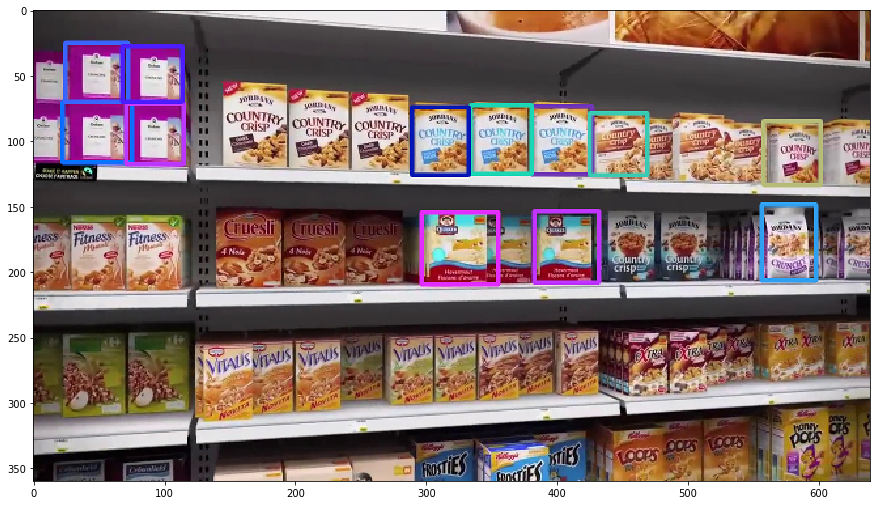

In [226]:
show_img(img_gif[50])

In [237]:
save_gif(img_gif,"./data/matches4.gif")

In [229]:
show_gif("./data/matches4.gif")

In [158]:
for match in matches_all2:
    print(match[0]['name'], len(match))

crunchy_violet 149
country_crisp_blue 135
country_crisp_blue 129
crunchy_violet 126
country_crisp_blue 123
country_crisp_blue 122
crunchy_violet 84
oxlem_pink 61
oxlem_pink 60
oxlem_pink 52
oxlem_pink 52
oxlem_pink 52
country_crisp_blue 52
oxlem_pink 51
oxlem_pink 50
oxlem_pink 50
oxlem_pink 50
crunchy_violet 50
oxlem_pink 49
oxlem_pink 49
oxlem_pink 48
country_crisp_blue 48
country_crisp_pink 48
oxlem_pink 47
oxlem_pink 46
crunchy_violet 46
crunchy_violet 39
country_crisp_pink 39
oxlem_pink 38
oxlem_pink 38
oxlem_pink 37
oxlem_pink 33
oxlem_pink 33
oxlem_pink 32
country_crisp_blue 32
oxlem_pink 31
oxlem_pink 30
oxlem_pink 30
oxlem_pink 28
country_crisp_pink 28
oxlem_pink 27
oxlem_pink 26
oxlem_pink 26
oxlem_pink 26
oxlem_pink 25
crunchy_violet 24
crunchy_violet 20
country_crisp_pink 17
country_crisp_blue 11
country_crisp_blue 11
crunchy_violet 11
oxlem_pink 10
crunchy_violet 10
oxlem_pink 9
crunchy_violet 9
country_crisp_blue 9
crunchy_violet 9
crunchy_violet 8
crunchy_violet 8
countr

In [129]:
# sorted(zip(chain_lens,matches_all2),key = lambda x:-x[0])

In [ ]:
cv2.perspectiveTransform(np.array([image1_cont]), M_all[0])

In [59]:
images[0].shape

(300, 300, 3)

In [69]:
point = np.array(get_centroid(preds_boxes[60][0]['box']))*300
cv2.perspectiveTransform(np.array([[point]]), M_all[0])[0][0]

array([20.40685552,  7.86097579])

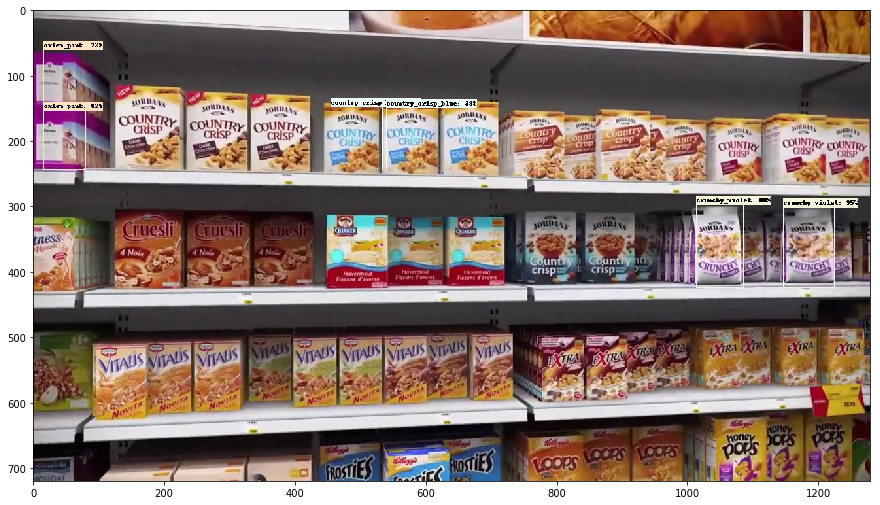

In [37]:
show_img(preds_imgs[60],(15,15))

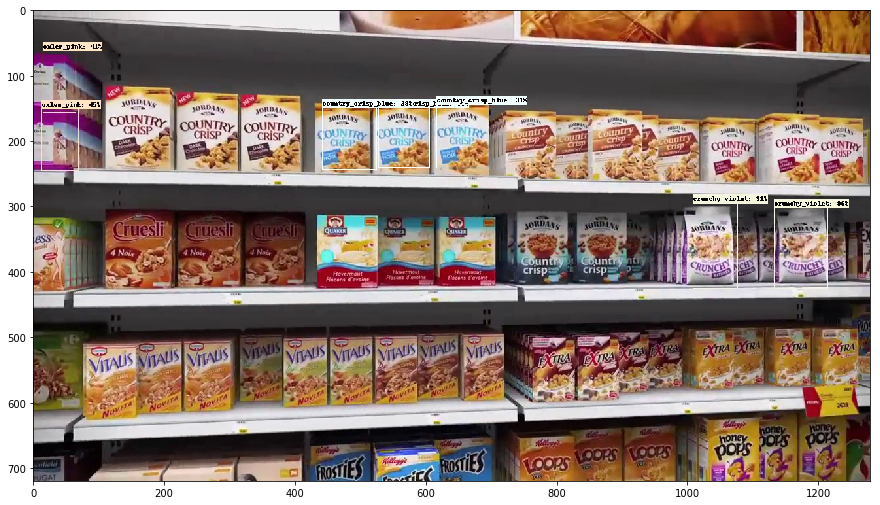

In [38]:
show_img(preds_imgs[61],(15,15))

In [20]:
# category_index2 = { category_index[key]:key for key,val in category_index }
get_predictions()

TypeError: 'int' object is not iterable

In [6]:
main_results = get_predictions([images[0]], category_index, detection_graph, 0.1)

ValueError: too many values to unpack (expected 3)

In [22]:
image_tmp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

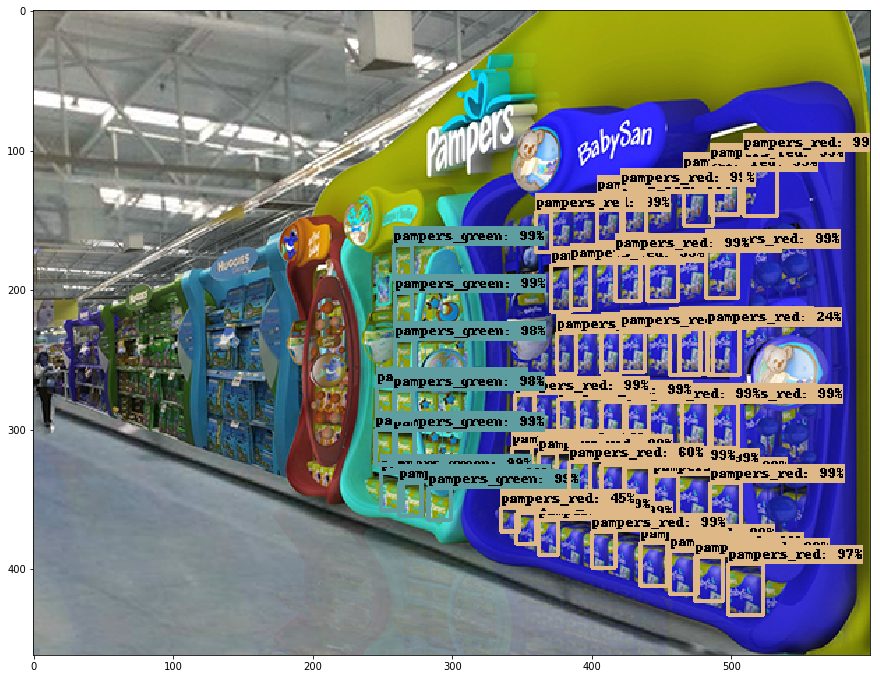

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(prediction)